In [191]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pandas import read_excel, melt, pivot_table, DataFrame, merge, concat
from scipy.stats import t, shapiro, normaltest, bartlett, levene, skew, kurtosis, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

In [109]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

# 연습문제 (ANOVA)

## 문제 1

다음은 소나무 품종별 무게를 조사한 데이터이다.

분석하라.


| A    | B    | C    |
|------|------|------|
| 4.17 | 4.81 | 6.31 |
| 5.58 | 4.17 | 5.12 |
| 5.18 | 4.41 | 5.54 |
| 6.11 | 3.59 | 5.5  |
| 4.5  | 5.87 | 5.37 |
| 4.61 | 3.83 | 5.29 |
| 5.17 | 6.03 | 4.92 |
| 4.53 | 4.89 | 6.15 |
| 5.33 | 4.32 | 5.8  |
| 5.14 | 4.69 | 5.26 |

> https://data.hossam.kr/mldata/tree_weight.xlsx

### [1] 데이터 가져오기

In [110]:
df1 = read_excel('https://data.hossam.kr/mldata/tree_weight.xlsx')
df1 # 일원분산분석

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A
5,4.61,A
6,5.17,A
7,4.53,A
8,5.33,A
9,5.14,A


### [2] 커널 밀도함수 및 신뢰구간 확인

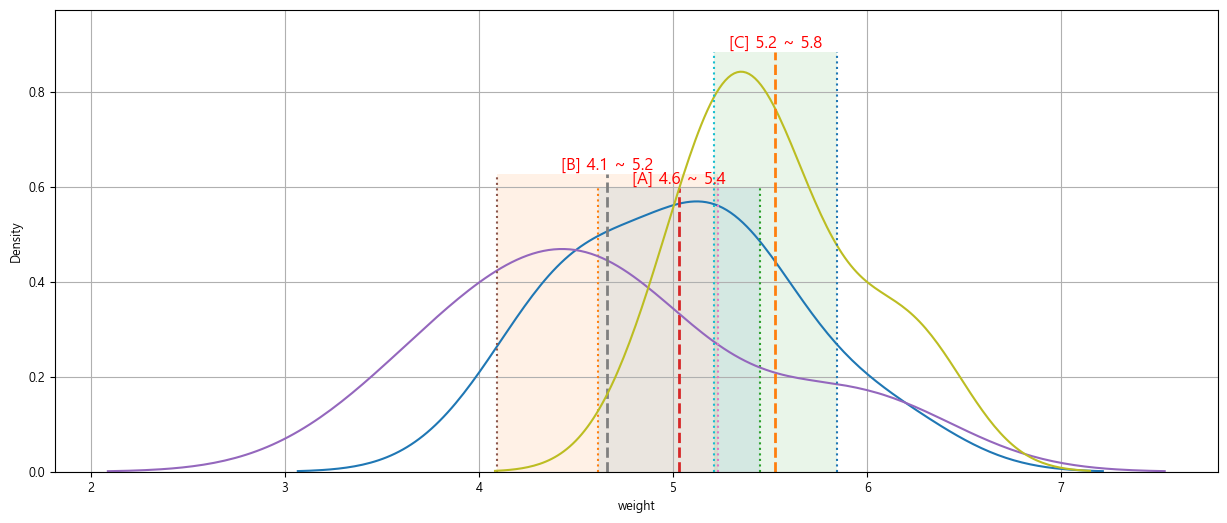

In [111]:
plt.figure()
for c in df1['group'].unique():
    #print(c)
    
    data = df1[df1['group']==c]['weight']
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [168]:
df1.head()


,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


### [3] 가설검정의 가정 확인

In [150]:
normal_dist = True      # 정규성 만족 여부
fields = []
for c in df1['group'].unique():
    data = df1[df1['group']==c]['weight']
    s, p = normaltest(data)
    # s, p = shapiro(data)
    fields.append(data)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    normal_dist = normal_dist and (p>0.05)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

[A] statistic: 0.233, p-value: 0.890, 정규성 충족 여부: True
[B] statistic: 0.968, p-value: 0.616, 정규성 충족 여부: True
[C] statistic: 1.013, p-value: 0.603, 정규성 충족 여부: True
Bartlett 검정: statistic: 2.879, p-value: 0.237, 등분산성 충족 여부: True


### [4] 일원분산분석 수행

In [115]:
lm = ols('weight ~ C(group)', data=df1).fit() # y = ax+b :: sales ~ C(store) ; R에서 쓰는 형식
anova = anova_lm(lm)
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

### [5] 사후검정 수행

In [116]:
tukey = pairwise_tukeyhsd(df1['weight'], df1['group'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.371,0.3909,-1.0622,0.3202,False
A,C,0.494,0.198,-0.1972,1.1852,False
B,C,0.865,0.012,0.1738,1.5562,True


> 그룹B와 그룹C의 평균이 다르다. 
>
> 평균의 차이는 0.865로 95%의 신뢰구간은 0.1738 ~ 1.5562 이다.
>
> A-B, A-C는 다르지 않다.

## 문제 2

다음은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터의 일부이다.

| time | poison | treat |
|------|--------|-------|
| 0.31 | 1      | A     |
| 0.45 | 1      | A     |
| 0.46 | 1      | A     |
| 0.43 | 1      | A     |
| 0.36 | 2      | A     |


> https://data.hossam.kr/mldata/poisons.xlsx

데이터의 각 변수는 다음과 같다.

| 필드 | 설명 |
|--|--|
| Time | 동물의 생존시간 |
| poison | 사용된 독극물 종류 |
| treat | 사용되는 치료 유형 |

사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.

### [1] 데이터 가져오기

In [117]:
df2 = read_excel('https://data.hossam.kr/mldata/poisons.xlsx')
df2.head() # 이원분산분석

,time,poison,treat
0,0.31,1,A
1,0.45,1,A
2,0.46,1,A
3,0.43,1,A
4,0.36,2,A


### [2] 가설검정의 가정 확인

In [152]:
독극물 = df2['poison'].unique()
치료방법 = df2['treat'].unique()
fields = []
normal_dist = True      # 정규성 만족 여부
   
for i in 독극물:
    for j in 치료방법:
        
        data = df2[(df2['poison'] == i) & (df2['treat'] == j)]['time']
        s = skew(data)
        k = kurtosis(data)  
        
        print(f"{i}번 독극물 {j}번 치료 유형","왜도의 절대값: %0.3f, 첨도의 절대값: %0.3f, 정규성 충족여부: %s" % (abs(s), abs(k), True if abs(s) <2 and abs(k) < 7 else False))
        # s, p = shapiro(data)
        # print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
        fields.append(data)
        
        normal_dist = normal_dist and (True if abs(s) <2 and abs(k) < 7 else False)

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

1번 독극물 A번 치료 유형 왜도의 절대값: 1.047, 첨도의 절대값: 0.756, 정규성 충족여부: True
1번 독극물 B번 치료 유형 왜도의 절대값: 0.586, 첨도의 절대값: 1.000, 정규성 충족여부: True
1번 독극물 C번 치료 유형 왜도의 절대값: 0.316, 첨도의 절대값: 1.573, 정규성 충족여부: True
1번 독극물 D번 치료 유형 왜도의 절대값: 0.796, 첨도의 절대값: 0.912, 정규성 충족여부: True
2번 독극물 A번 치료 유형 왜도의 절대값: 0.162, 첨도의 절대값: 1.478, 정규성 충족여부: True
2번 독극물 B번 치료 유형 왜도의 절대값: 0.354, 첨도의 절대값: 1.413, 정규성 충족여부: True
2번 독극물 C번 치료 유형 왜도의 절대값: 0.000, 첨도의 절대값: 1.449, 정규성 충족여부: True
2번 독극물 D번 치료 유형 왜도의 절대값: 0.365, 첨도의 절대값: 1.153, 정규성 충족여부: True
3번 독극물 A번 치료 유형 왜도의 절대값: 0.687, 첨도의 절대값: 1.000, 정규성 충족여부: True
3번 독극물 B번 치료 유형 왜도의 절대값: 0.000, 첨도의 절대값: 1.939, 정규성 충족여부: True
3번 독극물 C번 치료 유형 왜도의 절대값: 0.000, 첨도의 절대값: 1.360, 정규성 충족여부: True
3번 독극물 D번 치료 유형 왜도의 절대값: 0.499, 첨도의 절대값: 1.238, 정규성 충족여부: True
bartlett Test Result 
statistic: 45.137, p-value: 0.000, 등분산성 충족 여부: False


### [3] 분산분석 수행

In [119]:
formula = 'time ~ C(poison)*C(treat)'
lm = ols(formula, df2).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(poison),2.0,1.033012,0.516506,23.221737,3.331440e-07
C(treat),3.0,0.921206,0.307069,13.805582,3.777331e-06
C(poison):C(treat),6.0,0.250138,0.041690,1.874333,1.122506e-01
Residual,36.0,0.800725,0.022242,NaN,NaN


> 독극물과 치료방법에 대한 p값이 0.05보다 크므로 독극물과 치료방법에 대해 유의미한 효과가 없다고 할 수 있다.

## 문제 3

효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지 실험연구를 하여 다음 자료를 얻었다.

분산분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는지 검정하라.

<table>
    <tr>
        <th>효소함량</th>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
    </tr>
    <tr>
        <th>모종성장</th>
        <td>10.8</td>
        <td>9.1</td>
        <td>13.5</td>
        <td>9.2</td>
        <td>11.1</td>
        <td>11.2</td>
        <td>8.2</td>
        <td>11.3</td>
        <td>5.4</td>
        <td>4.6</td>
        <td>7.4</td>
        <td>5</td>
        <td>5.8</td>
        <td>5.3</td>
        <td>3.2</td>
        <td>7.5</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/tomato.xlsx

### [1] 데이터 가져오기

In [120]:
df3 = read_excel('https://data.hossam.kr/mldata/tomato.xlsx')
df3 # 일원분산분석


,효소함량,모종성장
0,0,10.8
1,0,9.1
2,0,13.5
3,0,9.2
4,1000,11.1
5,1000,11.2
6,1000,8.2
7,1000,11.3
8,5000,5.4
9,5000,4.6


### [2] 가설검정의 가정 확인

In [162]:
fields = []
normal_dist = True      # 정규성 만족 여부
   
for c in df3['효소함량'].unique():
    data = df3[df3['효소함량']==c]['모종성장']
    s = skew(data)
    k = kurtosis(data)  
    print(f"효소함량 {c}","왜도의 절대값: %0.3f, 첨도의 절대값: %0.3f, 정규성 충족여부: %s" % (abs(s), abs(k), True if abs(s) <2 and abs(k) < 7 else False))

    # s, p = shapiro(data)
    # print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    fields.append(data)
    
    normal_dist = normal_dist and (True if abs(s) <2 and abs(k) < 7 else False)

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

효소함량 0 왜도의 절대값: 0.728, 첨도의 절대값: 1.096, 정규성 충족여부: True
효소함량 1000 왜도의 절대값: 1.144, 첨도의 절대값: 0.675, 정규성 충족여부: True
효소함량 5000 왜도의 절대값: 0.922, 첨도의 절대값: 0.839, 정규성 충족여부: True
효소함량 10000 왜도의 절대값: 0.190, 첨도의 절대값: 1.044, 정규성 충족여부: True
bartlett Test Result 
statistic: 0.713, p-value: 0.870, 등분산성 충족 여부: True


### [3] 분산분석 수행

In [122]:
lm = ols('모종성장 ~ C(효소함량)', data=df3).fit()
anova = anova_lm(lm)
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 12.086, p-value: 0.001, 대립가설 채택'

### [4] 사후검정 수행

In [123]:
tukey = pairwise_tukeyhsd(df3['모종성장'], df3['효소함량'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1000,-0.2,0.9982,-3.706,3.306,False
0,5000,-5.05,0.0051,-8.556,-1.544,True
0,10000,-5.2,0.0041,-8.706,-1.694,True
1000,5000,-4.85,0.0069,-8.356,-1.344,True
1000,10000,-5.0,0.0055,-8.506,-1.494,True
5000,10000,-0.15,0.9992,-3.656,3.356,False


> 효소함량 0과 1000의 평균이 다르다
>
> 평균의 차이는 -0.2로 95%의 신뢰구간은 -3.706 ~ 3.306 이다.
>
> 효소함량 5000과 10000의 평균이 다르다
>
> 평균의 차이는 -0.15로 95%의 신뢰구간은 -3.656 ~ 3.356 이다.

## 문제 4

유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 다음과 같은 독서평가 점수자료를 얻었다.

세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

<table>
    <tr>
        <th>독서방법</th>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
    </tr>
    <tr>
        <th>점수</th>
        <td>6</td>
        <td>9</td>
        <td>2</td>
        <td>16</td>
        <td>7</td>
        <td>7</td>
        <td>12</td>
        <td>10</td>
        <td>16</td>
        <td>11</td>
        <td>7</td>
        <td>4</td>
        <td>7</td>
        <td>7</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/reading.xlsx

### [1] 데이터 가져오기

In [124]:
df4 = read_excel('https://data.hossam.kr/mldata/reading.xlsx')
df4 # 일원분산분석

,독서방법,점수
0,B,6
1,B,9
2,B,2
3,B,16
4,D,7
5,D,7
6,D,12
7,D,10
8,D,16
9,S,11


### [2] 가설검정의 가정 확인

In [159]:
fields = []
normal_dist = True      # 정규성 만족 여부
   
for c in df4['독서방법'].unique():
    data = df4[df4['독서방법']==c]['점수']
    s = skew(data)
    k = kurtosis(data)  
    print(f"독서방법 {c}","왜도의 절대값: %0.3f, 첨도의 절대값: %0.3f, 정규성 충족여부: %s" % (abs(s), abs(k), True if abs(s) <2 and abs(k) < 7 else False))
    # s, p = shapiro(data)
    # print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    fields.append(data)
    
    normal_dist = normal_dist and (True if abs(s) <2 and abs(k) < 7 else False)

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

독서방법 B 왜도의 절대값: 0.392, 첨도의 절대값: 1.119, 정규성 충족여부: True
독서방법 D 왜도의 절대값: 0.522, 첨도의 절대값: 1.079, 정규성 충족여부: True
독서방법 S 왜도의 절대값: 0.400, 첨도의 절대값: 0.452, 정규성 충족여부: True
bartlett Test Result 
statistic: 2.271, p-value: 0.321, 등분산성 충족 여부: True


### [3] 분산분석 수행

In [126]:
lm = ols('점수 ~ C(독서방법)', data=df4).fit()
anova = anova_lm(lm)
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.779, p-value: 0.482, 귀무가설 채택'

> 독서방법별 점수에는 차이가 없다

### [4] 사후검정 수행

In [127]:
comp = MultiComparison(df4['점수'], df4['독서방법'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
B,D,-0.6663,0.5265,1.0,False
B,S,0.3638,0.7267,1.0,False
D,S,1.5804,0.1527,0.458,False


## 문제 5

두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적이 다음과 같다.

이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지 검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요합니다.)

<table>
    <tr>
        <th>교육방법</th>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
    </tr>
    <tr>
        <th>국어</th>
        <td>65</td>
        <td>87</td>
        <td>73</td>
        <td>79</td>
        <td>81</td>
        <td>69</td>
        <td>55</td>
        <td>76</td>
        <td>77</td>
        <td>70</td>
        <td>88</td>
        <td>75</td>
        <td>69</td>
        <td>83</td>
        <td>81</td>
        <td>72</td>
        <td>79</td>
        <td>85</td>
        <td>89</td>
        <td>90</td>
        <td>77</td>
        <td>95</td>
    </tr>
    <tr>
        <th>영어</th>
        <td>82</td>
        <td>79</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>70</td>
        <td>79</td>
        <td>80</td>
        <td>76</td>
        <td>90</td>
        <td>68</td>
        <td>72</td>
        <td>75</td>
        <td>93</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>88</td>
        <td>92</td>
        <td>83</td>
        <td>93</td>
        <td>78</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/edu.xlsx

### [1] 데이터 가져오기

In [128]:
df5 = read_excel('https://data.hossam.kr/mldata/edu.xlsx')
df5


,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65
5,1,69,70
6,1,55,79
7,1,76,80
8,1,77,76
9,1,70,90


### [2] 가설검정의 가정 확인

In [129]:
df5_1 = melt(df5, id_vars= '교육방법',
value_vars = ['국어','영어'],
var_name = '과목명',value_name = '점수')
df5_1

,교육방법,과목명,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81
5,1,국어,69
6,1,국어,55
7,1,국어,76
8,1,국어,77
9,1,국어,70


In [157]:
normal_dist = True  
for i in df5_1['교육방법'].unique():
    for j in df5_1['과목명'].unique():
        data = df5_1[(df5_1['교육방법'] == i) & (df5_1['과목명'] == j)]['점수']
        s, p = normaltest(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p > 0.05))
        nonormal_dist = normal_dist and (p > 0.05)
if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

[1 + 국어] statistic: 0.911, p-value: 0.634, 정규성 충족 여부: True
[1 + 영어] statistic: 0.389, p-value: 0.823, 정규성 충족 여부: True
[2 + 국어] statistic: 0.300, p-value: 0.861, 정규성 충족 여부: True
[2 + 영어] statistic: 1.095, p-value: 0.578, 정규성 충족 여부: True
bartlett Test Result 
statistic: 2.271, p-value: 0.321, 등분산성 충족 여부: True


### [3] 분산분석 수행

In [131]:
formula = '점수 ~ C(교육방법)*C(과목명)'
lm = ols(formula, df5_1).fit()
anova = anova_lm(lm,typ=2)
anova

,sum_sq,df,F,PR(>F)
C(교육방법),355.113636,1.0,3.845870,0.056857
C(과목명),0.204545,1.0,0.002215,0.962695
C(교육방법):C(과목명),14.204545,1.0,0.153835,0.696979
Residual,3693.454545,40.0,NaN,NaN


> 교육방법에 대한 p값이 0.05보다 크므로 교육방법에 따른 성적은 통계적으로 유의미한 차이가 있다.
>
> 과목명에 대한 p값이 0.05보다 크므로 과목에 따른 성적은 통계적으로 유의미한 차이가 있다.
>
> 교육방법과 과목명에 대한 p값이 0.05보다 크므로 교육방법과 과목의 상호작용이 성적에 교효작용이 있다고 볼 수 있다.

## 문제 6

서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.

주어진 데이터는 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.

> https://data.hossam.kr/mldata/commercial.xlsx

### 1) 상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.



#### [1] 데이터 가져오기

In [132]:
df6 = read_excel('https://data.hossam.kr/mldata/commercial.xlsx')
df6

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166
...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13523478306,535132
6218,4,3130324,전통시장,길동복조리시장,6236556030,330148
6219,4,3130325,전통시장,명일전통시장,3973269286,186049
6220,4,3130326,전통시장,고덕 골목형상점가,15013907999,755565


#### [2] 가설검정의 확인

In [133]:
normal_dist = True
data = []
for i in df6['type'].unique():
    df6_1 = df6[df6["type"] == i]['sales_amount']
    s, p = normaltest(df6_1)
    data.append(df6_1)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(i, s, p, p > 0.05))
    normal_dist = normal_dist and (p > 0.05)
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*data)
else:
    n = "Levene"
    s, p = levene(*data)

equal_var = p > 0.05
print("[{0} 검정] statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, equal_var))


[관광특구] statistic: 2.023, p-value: 0.364, 정규성 충족 여부: True
[골목상권] statistic: 2949.769, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 1174.364, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 1194.780, p-value: 0.000, 정규성 충족 여부: False
[Levene 검정] statistic: 268.725, p-value: 0.000, 등분산성 충족 여부: False


In [134]:
df6_1 = df6[['type','sales_amount']]
df6_1

,type,sales_amount
0,관광특구,72523644100
1,관광특구,283332346393
2,관광특구,81696730221
3,관광특구,212062656625
4,관광특구,231338386876
...,...,...
6217,전통시장,13523478306
6218,전통시장,6236556030
6219,전통시장,3973269286
6220,전통시장,15013907999


#### [3] 분산분석 수행

In [135]:
lm = ols('sales_amount ~ C(type)', data=df6_1).fit() # y = ax+b :: sales ~ C(store) ; R에서 쓰는 형식
anova = anova_lm(lm)
print(anova)
# PR(>F) : p-value, F : statistic

              df        sum_sq       mean_sq           F  PR(>F)
C(type)      3.0  3.397583e+24  1.132528e+24  612.136531     0.0
Residual  6218.0  1.150406e+25  1.850123e+21         NaN     NaN


#### [4] 사후검정 수행

In [136]:
result = pairwise_gameshowell(df6_1, dv='sales_amount', between='type')
result # 유의미한 변수 : mean, diff, pval 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509e+09,2.281432e+11,-2.244837e+11,2.289216e+10,-9.806138,23.000501,6.410146e-09,-23.206979
1,골목상권,발달상권,3.659509e+09,5.706310e+10,-5.340359e+10,3.282878e+09,-16.267309,996.054989,7.271961e-14,-1.160433
2,골목상권,전통시장,3.659509e+09,1.058420e+10,-6.924689e+09,6.060559e+08,-11.425826,1143.188337,0.000000e+00,-0.679464
3,관광특구,발달상권,2.281432e+11,5.706310e+10,1.710801e+11,2.312611e+10,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,2.281432e+11,1.058420e+10,2.175590e+11,2.289993e+10,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,5.706310e+10,1.058420e+10,4.647890e+10,3.336641e+09,13.929848,1061.849622,3.926859e-13,0.638976


> 모든 상권의 평균은 통계적으로 유의미한 차이가 있다($P<0.05$)

### 2) 상권 종류별로 2023년 분기별 평균 매출액은 어떤 차이가 보이는지 분석하라.

In [137]:
df6

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166
...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13523478306,535132
6218,4,3130324,전통시장,길동복조리시장,6236556030,330148
6219,4,3130325,전통시장,명일전통시장,3973269286,186049
6220,4,3130326,전통시장,고덕 골목형상점가,15013907999,755565


In [145]:
for t in df6['type'].unique():
    print(t)
    print("-" * 30)
    df6_2 = df6[df6['type'] == t][['quarter', 'sales_amount']]
    q0 = np.log(df6_2[df6_2['quarter'] == 1]['sales_amount'])
    q1 = np.log(df6_2[df6_2['quarter'] == 2]['sales_amount'])
    q2 = np.log(df6_2[df6_2['quarter'] == 3]['sales_amount'])
    q3 = np.log(df6_2[df6_2['quarter'] == 4]['sales_amount'])

    normal_dist = True      # 정규성 만족 여부
    data = [q0, q1, q2, q3]
    
    # 정규성 확인
    for i, c in enumerate(data):
        s = skew(c)
        k = kurtosis(c)  
        print(f"{t} {i+1}분기","왜도의 절대값: %0.3f, 첨도의 절대값: %0.3f, 정규성 충족여부: %s" % (abs(s), abs(k), True if abs(s) <2 and abs(k) < 7 else False))
        normal_dist = normal_dist and (p > 0.05)


    # 등분산성 확인
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data)
    else:
        n = "Levene"
        s, p = levene(*data)

    equal_var = p > 0.05
    print("[{0} 검정] statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, equal_var))

관광특구
------------------------------
관광특구 1분기 왜도의 절대값: 0.615, 첨도의 절대값: 1.446, 정규성 충족여부: True
관광특구 2분기 왜도의 절대값: 0.322, 첨도의 절대값: 1.413, 정규성 충족여부: True
관광특구 3분기 왜도의 절대값: 0.321, 첨도의 절대값: 1.507, 정규성 충족여부: True
관광특구 4분기 왜도의 절대값: 0.396, 첨도의 절대값: 1.332, 정규성 충족여부: True
[Bartlett 검정] statistic: 0.257, p-value: 0.968, 등분산성 충족 여부: True
골목상권
------------------------------
골목상권 1분기 왜도의 절대값: 0.933, 첨도의 절대값: 1.395, 정규성 충족여부: True
골목상권 2분기 왜도의 절대값: 1.284, 첨도의 절대값: 3.393, 정규성 충족여부: True
골목상권 3분기 왜도의 절대값: 1.233, 첨도의 절대값: 3.053, 정규성 충족여부: True
골목상권 4분기 왜도의 절대값: 1.130, 첨도의 절대값: 2.814, 정규성 충족여부: True
[Bartlett 검정] statistic: 0.989, p-value: 0.804, 등분산성 충족 여부: True
발달상권
------------------------------
발달상권 1분기 왜도의 절대값: 0.400, 첨도의 절대값: 2.103, 정규성 충족여부: True
발달상권 2분기 왜도의 절대값: 0.490, 첨도의 절대값: 2.194, 정규성 충족여부: True
발달상권 3분기 왜도의 절대값: 0.478, 첨도의 절대값: 2.041, 정규성 충족여부: True
발달상권 4분기 왜도의 절대값: 0.456, 첨도의 절대값: 2.260, 정규성 충족여부: True
[Bartlett 검정] statistic: 0.051, p-value: 0.997, 등분산성 충족 여부: True
전통시장
--------------------

In [147]:
lm = ols('sales_amount ~ C(type)*C(quarter)', df6).fit()
anova = anova_lm(lm, tpy=2)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(type),3.0,3.397583e+24,1.132528e+24,612.997343,0.000000
C(quarter),3.0,6.915692e+21,2.305231e+21,1.247740,0.290658
C(type):C(quarter),9.0,3.140937e+22,3.489930e+21,1.888976,0.048918
Residual,6206.0,1.146574e+25,1.847525e+21,NaN,NaN


> 상권 종류별에 대한 p값이 0.05보다 작으므로 상권 종류별에 따른 매출액의 평균은 통계적으로 유의미한 차이가 있다
>
> 분기별에 대한 p값이 0.05보다 크므로 분기별에 대한 매출액의 평균은 통계적으로 유의미한 차이가 없다
>
> 상권종류별과 분기별에 대한 p값이 0.05보다 작으므로 상권종류별과 분기별의 매출액에 교효작용이 있다고 볼 수 있다.
